# stock dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator
from opendataval.model.mlp import RegressionMLP

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment

### [Step 1-1] Define a DataFetcher from a registered dataset
`ExperimentMediator.model_factory_setup()` is convenient, but it only works for datasets registered in `opendataval`. To apply `opendataval` to your custome datasets, a user first needs to define a `DataFetcher` from a registered dataset. 

In [2]:
dataset_name = "stock"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
metric_name = "neg_mse"

fetcher = (
    DataFetcher(dataset_name, '../data_files/', False)
    .split_dataset_by_count(train_count,
                            valid_count,
                            test_count)  
    .noisify(add_gauss_noise, noise_rate=noise_rate)
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. The following code defines a multi-layer perceptron with two hidden layers. Each hidden layer has 25 nodes.

In [3]:
pred_model = RegressionMLP(fetcher.covar_dim[0], layers=2, hidden_dim=25)

### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.001220


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 294.54it/s]


Elapsed time LeaveOneOut(): 0:00:01.279929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.43it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:02.771242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 313.94it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:06.391010


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13820.47it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.013839
Start: marginal contribution computation



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.22it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


gr_stat=100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]

gr_stat=1.0274854164066323
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:57.662713
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 476.31it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:02.106060


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 365.38it/s]


Elapsed time AME(num_models=1000): 0:00:08.294644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 279.29it/s]


Elapsed time DataOob(num_models=1000): 0:00:03.585900


Elapsed time LavaEvaluator(): 0:00:00.023713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 207.10it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:01.452819
CPU times: user 1min 22s, sys: 420 ms, total: 1min 22s
Wall time: 1min 23s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/stock_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.186916
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.162162
DVRL(rl_epochs=2000),0.200000
DataBanzhaf(num_models=1000),0.241379
DataOob(num_models=1000),0.190476
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.176471
InfluenceFunctionEval(num_models=1000),0.140351
KNNShapley(k_neighbors=50),0.181818
LavaEvaluator(),0.421053
LeaveOneOut(),0.123077


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

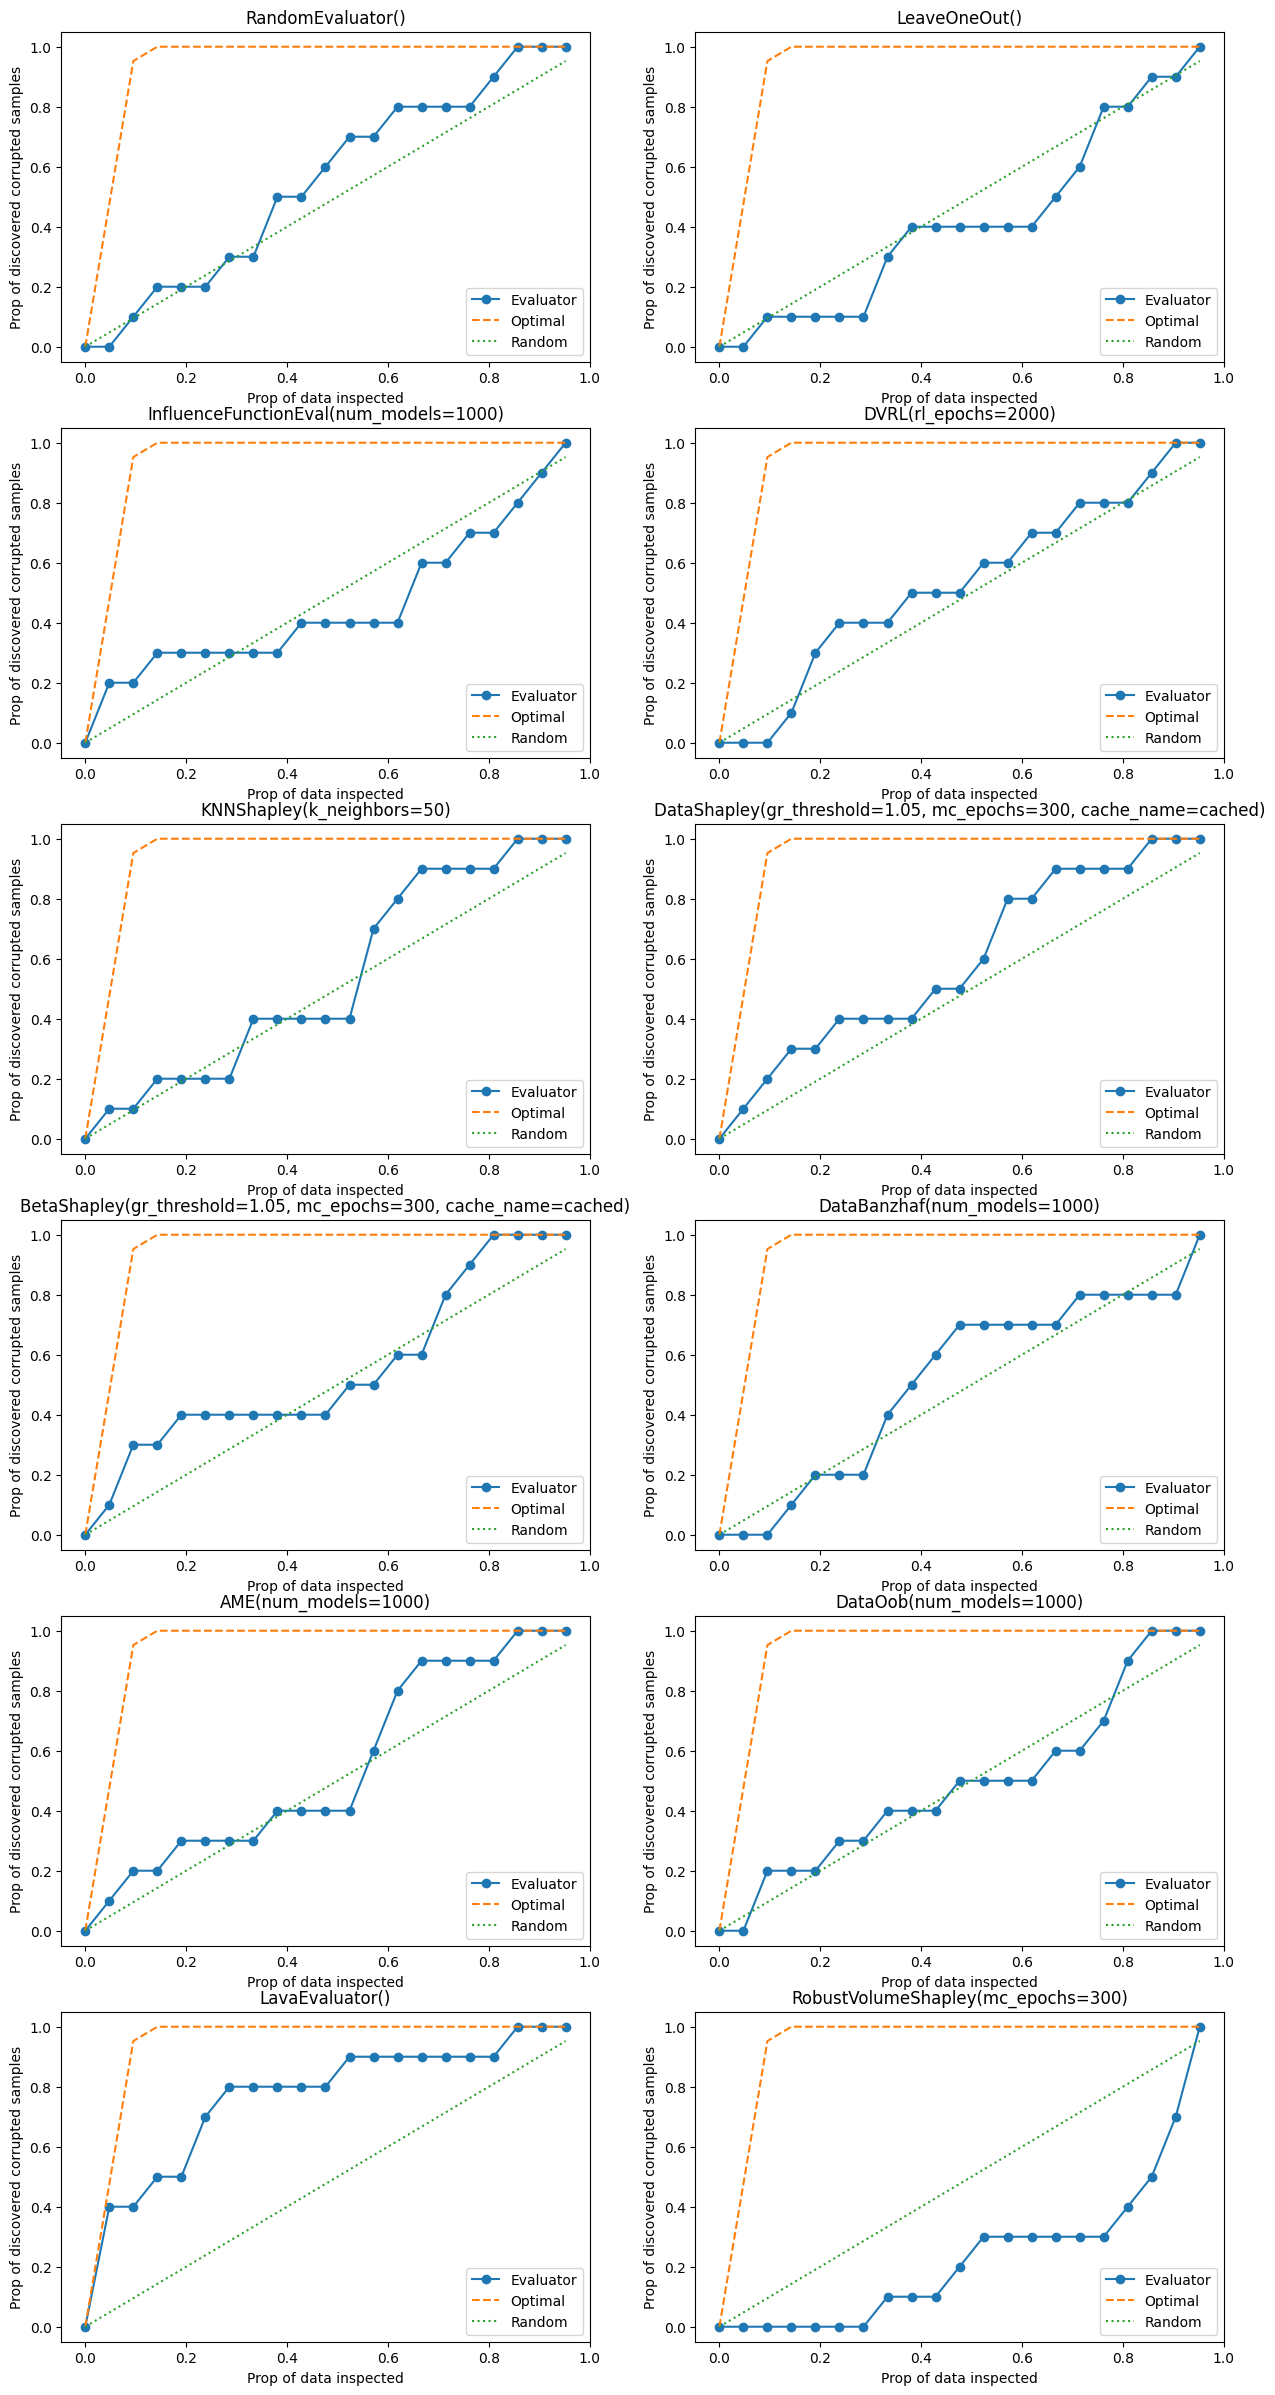

In [9]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

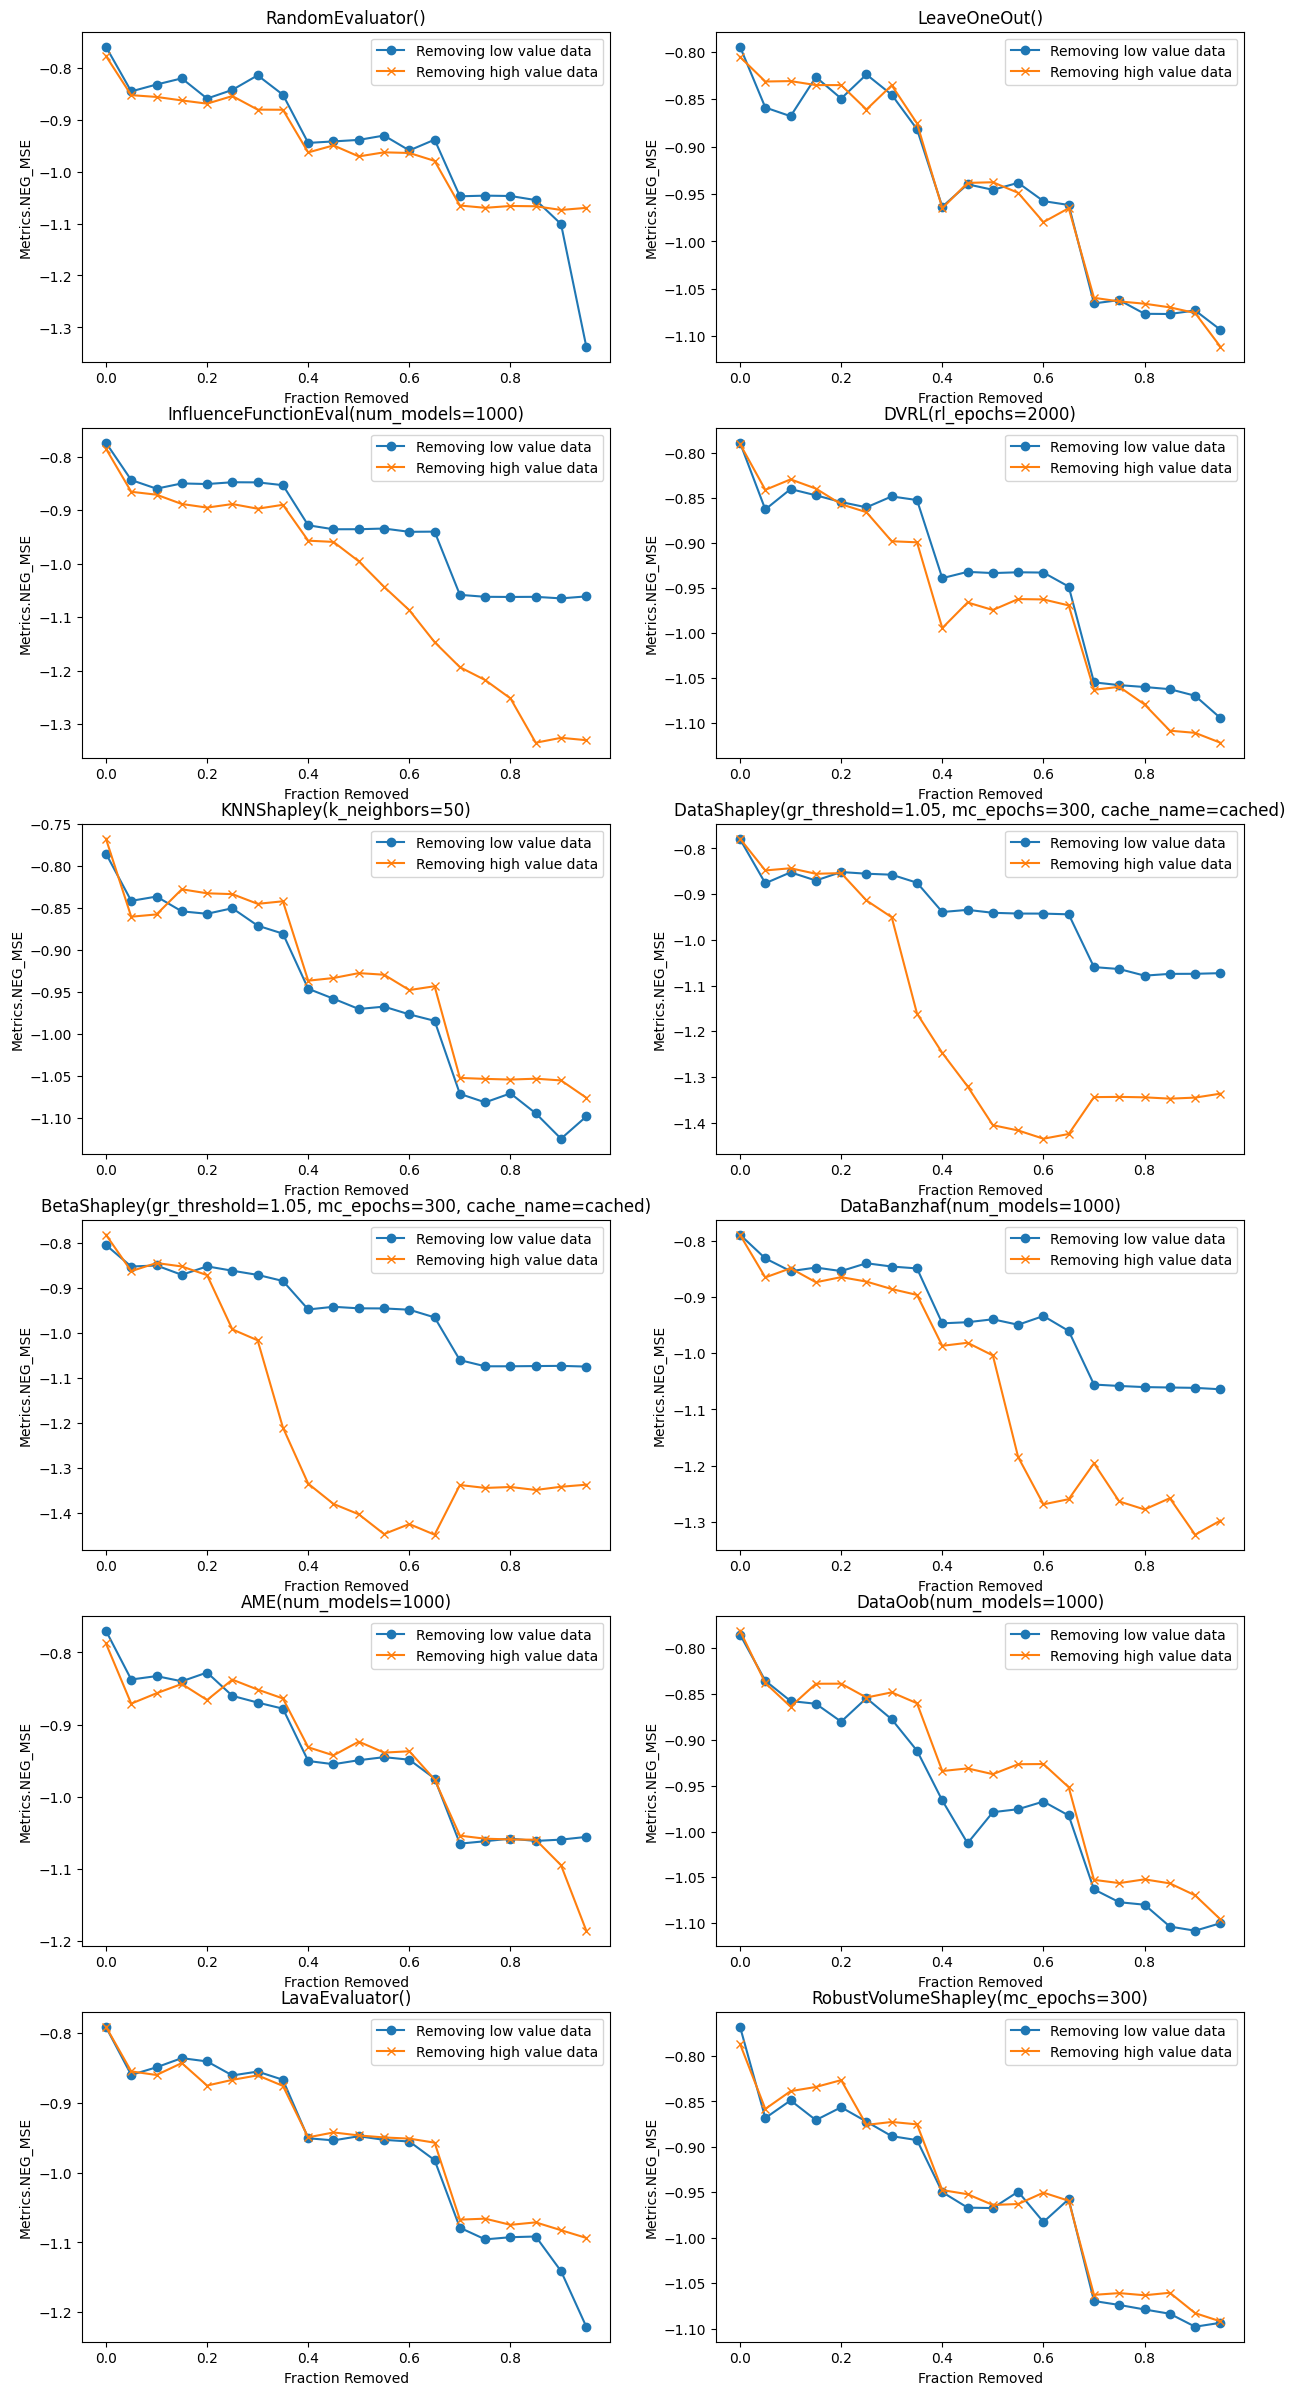

In [10]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-0.759863,-0.777681,0.0
RandomEvaluator(),-0.845818,-0.853059,0.05
RandomEvaluator(),-0.832592,-0.856476,0.1
RandomEvaluator(),-0.820733,-0.863177,0.15
RandomEvaluator(),-0.859556,-0.869391,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),-1.073825,-1.06078,0.75
RobustVolumeShapley(mc_epochs=300),-1.078778,-1.063153,0.8
RobustVolumeShapley(mc_epochs=300),-1.083511,-1.060419,0.85
RobustVolumeShapley(mc_epochs=300),-1.097766,-1.082821,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),9708,0.857403
RandomEvaluator(),7316,0.309829
RandomEvaluator(),14021,0.54757
RandomEvaluator(),15562,0.598235
RandomEvaluator(),31137,0.8238
...,...,...
RobustVolumeShapley(mc_epochs=300),58484,1277.590073
RobustVolumeShapley(mc_epochs=300),11033,1116.746875
RobustVolumeShapley(mc_epochs=300),57510,614.16582
RobustVolumeShapley(mc_epochs=300),41144,1231.278971
